In [1]:
import os
import re
import pandas as pd
from transformers import pipeline
from datetime import datetime
import numpy as np
from tqdm import tqdm
from collections import Counter
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableSequence
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('key_luis_lazarte.txt') as f:
  apikey = f.read()
os.environ["OPENAI_API_KEY"] = apikey

In [3]:
contenidos = []

for sample in os.listdir('sample'):
    if sample.endswith(".txt"):
        with open('sample' + '/' + sample, "r", encoding="utf-8") as archivo:
            contenido = archivo.read()
            contenidos.append(contenido)

In [4]:
lista_transcripcion = []
lista_duracion_llamada = []
lista_texto_cliente = []
lista_texto_agente = []
lista_texto_supervisor = []
lista_inicio_supervisor = []
lista_duracion_supervisor = []
lista_sentimiento = []
lista_reason = []
lista_problem = []
lista_need =[]
analizador = pipeline("sentiment-analysis", model="pysentimiento/robertuito-sentiment-analysis")

Device set to use cpu


In [5]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [6]:
reason_prompt = ChatPromptTemplate.from_messages([
    ("system", "You're a bilingual assistant que identifica el main reason del contacto del cliente. Resume el motivo en una frase short y directa, sin usar palabras como 'consulta', 'pregunta', 'llamada' o nombres. Just el core issue."),
    ("user", "Read esta conversación y dime el motivo principal por el que el cliente contactó. Solo responde con el tema, sin contexto, sin saludos y sin verbos como 'llamar' o 'consultar':\n{transcipcion}")
])

problem_prompt = ChatPromptTemplate.from_messages([
    ("system", "You're a bilingual assistant que analiza conversaciones con clientes y extrae directamente el problema, error o insatisfacción si existe."),
    ("user", "Read esta conversación con el cliente. Si hay un problema, escribe solo el problema reported en una frase corta. No incluyas introducciones como 'El cliente dice que...'. Si no hay problema, responde 'ninguno':\n{transcipcion}")
])

needs_prompt = ChatPromptTemplate.from_messages([
    ("system", 
     "You're a bilingual assistant que analiza customer conversations y detecta unmet needs — pueden ser explícitas (el cliente las dice claro) o implícitas (se infieren por el contexto, tono o lo que el cliente da a entender). También puedes sugerir una unmet need si crees que hay una necesidad subyacente aunque no se diga directo."),
    ("user", 
     "Read esta conversación. Si encuentras una necesidad no satisfecha, o puedes inferir una probable unmet need, escríbela en una frase short, clear y directa — no expliques, no copies frases, no des contexto. Si no hay ninguna unmet need, responde solo con: 'none'.\n\n{transcipcion}")
])

In [7]:
for transcipcion in tqdm(contenidos):
    
    timestamps = re.findall(r"\[(\d{2}:\d{2}:\d{2})\]", transcipcion)
    duracion_llamada = timestamps[-1] if timestamps else None

    mensajes_cliente = re.findall(r"\[\d{2}:\d{2}:\d{2}\] CLIENTE: (.*)", transcipcion)
    mensajes_agente = re.findall(r"\[\d{2}:\d{2}:\d{2}\] AGENTE: (.*)", transcipcion)

    texto_cliente = "\n".join(mensajes_cliente)
    texto_agente = "\n".join(mensajes_agente)

    try:
        inicio_supervisor = re.search(r'\[(\d{2}:\d{2}:\d{2})\]\s+SUPERVISOR:', transcipcion).group(1)
        duracion_supervisor = datetime.strptime(duracion_llamada, "%H:%M:%S") - datetime.strptime(inicio_supervisor, "%H:%M:%S")
        mensajes_supervisor = re.findall(r"\[\d{2}:\d{2}:\d{2}\] SUPERVISOR: (.*)", transcipcion)
        texto_supervisor = "\n".join(mensajes_supervisor)
        inicio_supervisor = datetime.strptime(inicio_supervisor, "%H:%M:%S").hour * 60 + datetime.strptime(inicio_supervisor, "%H:%M:%S").minute + datetime.strptime(inicio_supervisor, "%H:%M:%S").second / 60
        duracion_supervisor = duracion_supervisor.seconds / 60

        lista_texto_supervisor.append(texto_supervisor)
        lista_inicio_supervisor.append(inicio_supervisor)
        lista_duracion_supervisor.append(duracion_supervisor)
    except:
        lista_texto_supervisor.append(np.NaN)
        lista_inicio_supervisor.append(np.NaN)
        lista_duracion_supervisor.append(np.NaN)

    duracion_llamada = datetime.strptime(duracion_llamada, "%H:%M:%S").hour * 60 + datetime.strptime(duracion_llamada, "%H:%M:%S").minute + datetime.strptime(duracion_llamada, "%H:%M:%S").second / 60

    clase = []
    for msg in mensajes_cliente:
        clase.append(analizador(msg)[0]['label'])
    
    conteo = Counter(clase)
    moda = conteo.most_common(1)[0][0]

    lista_transcripcion.append(transcipcion)
    lista_duracion_llamada.append(duracion_llamada)
    lista_texto_cliente.append(texto_cliente)
    lista_texto_agente.append(texto_agente)
    lista_sentimiento.append(moda)

    transcipcion = re.sub(r"\[\d{2}:\d{2}:\d{2}\]\s*", "", transcipcion)
    pipeline_reason = RunnableSequence(reason_prompt | llm | StrOutputParser())
    pipeline_problem = RunnableSequence(problem_prompt | llm | StrOutputParser())
    pipeline_need = RunnableSequence(needs_prompt | llm | StrOutputParser())

    output_reason = pipeline_reason.invoke({"transcipcion": transcipcion})
    output_problem = pipeline_problem.invoke({"transcipcion": transcipcion})
    output_need = pipeline_need.invoke({"transcipcion": transcipcion})

    lista_reason.append(output_reason)
    lista_problem.append(output_problem)
    lista_need.append(output_need)

100%|██████████| 100/100 [05:05<00:00,  3.05s/it]


In [8]:
df = pd.DataFrame({
    'transcipcion': lista_transcripcion,
    'duracion llamada': lista_duracion_llamada,
    'duracion cliente - agente': lista_inicio_supervisor,
    'duracion cliente - supervisor': lista_duracion_supervisor,
    'texto de cliente': lista_texto_cliente,
    'texto de agente': lista_texto_agente,
    'texto de supervisor': lista_texto_supervisor,
    'sentimiento de cliente': lista_sentimiento,
    'motivo de contacto': lista_reason,
    'problema reportado': lista_problem,
    'necesidad no satisfecha': lista_need
})

In [9]:
df['sentimiento de cliente'].value_counts()

sentimiento de cliente
NEU    86
NEG    14
Name: count, dtype: int64

In [10]:
df

,transcipcion,duracion llamada,duracion cliente - agente,duracion cliente - supervisor,texto de cliente,texto de agente,texto de supervisor,sentimiento de cliente,motivo de contacto,problema reportado,necesidad no satisfecha
0,"[00:00:00] AGENTE: . Buenos días, le atiende C...",3.133333,NaN,NaN,"Hola, buen día. Soy Mariana López.\nEstoy llam...",". Buenos días, le atiende Carlos. ¿Con quién t...",NaN,NEU,Cargo adicional en la factura.,Cargo adicional en la factura que el cliente n...,La cliente podría necesitar una mejor comunica...
1,"[00:00:00] AGENTE: . Buenas tardes, le habla C...",2.416667,NaN,NaN,"Hola, buenas tardes. Soy José Ramírez y necesi...",". Buenas tardes, le habla Claudia. ¿En qué pue...",NaN,NEU,Problemas de conexión a internet.,Problema con la estabilidad de la señal de int...,none
2,"[00:00:00] AGENTE: . Buen día, le saluda Luis....",2.233333,NaN,NaN,"Hola, buen día. Mi nombre es Ana Rodríguez, es...",". Buen día, le saluda Luis. ¿En qué puedo ayud...",NaN,NEU,Aumento de datos en el plan de telefonía móvil.,ninguno,none
3,"[00:00:00] AGENTE: . Buenas tardes, mi nombre ...",1.666667,NaN,NaN,"Buenas tardes, Laura. Soy Pablo Méndez y llamo...",". Buenas tardes, mi nombre es Laura. ¿En qué p...",NaN,NEU,Problema con la recepción de canales de televi...,No veo algunos canales.,none
4,"[00:00:00] AGENTE: . Buenas tardes, le habla M...",3.450000,NaN,NaN,"Buenas tardes, Martín. Mi nombre es Lucía Fern...",". Buenas tardes, le habla Martín. ¿En qué pued...",NaN,NEU,Problemas con la velocidad de internet.,"Problema con la velocidad de internet, especia...",none
...,...,...,...,...,...,...,...,...,...,...,...
95,"[00:00:00] AGENTE: Buenas tardes, le habla Rob...",3.366667,NaN,NaN,¡Esto ya es el colmo! Mi nombre es Fernando Ma...,"Buenas tardes, le habla Roberto Gómez de <LOCA...",NaN,NEG,Problemas de cobertura y calidad en las llamadas.,Problema de cobertura y calidad en las llamadas.,El cliente necesita una solución rápida y efec...
96,"[00:00:00] AGENTE: Buenas tardes, le habla Jav...",3.066667,NaN,NaN,"Buenas tardes, Javier. Mi nombre es Claudia Gó...","Buenas tardes, le habla Javier Martínez de <LO...",NaN,NEG,Cobro indebido tras solicitud de cancelación d...,Se realizó un nuevo cobro a la cliente a pesar...,Necesita un sistema de gestión de suscripcione...
97,"[00:00:00] AGENTE: Buenas tardes, le habla Ser...",3.016667,NaN,NaN,"Buenas tardes, Sergio. Mi nombre es Laura Fern...","Buenas tardes, le habla Sergio Ruiz de <LOCATI...",NaN,NEG,Retraso en la entrega de un pedido.,El producto no ha llegado a tiempo y el client...,La cliente necesita una comunicación más proac...
98,"[00:00:00] AGENTE: Buenas tardes, le habla Cla...",3.550000,NaN,NaN,¡Esto ya está fuera de control! Mi nombre es E...,"Buenas tardes, le habla Claudia Morales de <LO...",NaN,NEG,Interrupción del servicio de internet.,El cliente está sin conexión a internet desde ...,El cliente necesita una solución rápida y efec...


In [11]:
df['motivo de contacto'].value_counts()

motivo de contacto
Problemas de conexión a internet.                      4
Cargo adicional en la factura.                         3
Baja de servicios.                                     2
Interrupción del servicio de internet.                 2
Retraso en la entrega de un pedido.                    2
                                                      ..
Interrupción del servicio de internet y televisión.    1
Cambio de compañía y portabilidad del número.          1
Problema con un cobro elevado en la factura.           1
Problema de conexión a internet.                       1
Producto defectuoso.                                   1
Name: count, Length: 90, dtype: int64

In [12]:
df['problema reportado'].value_counts()

problema reportado
ninguno                                                                                                                          16
Ninguno.                                                                                                                          3
Cargo adicional en la factura que el cliente no reconoce.                                                                         2
El cliente no sabía que tenía permanencia y preguntó si había forma de evitar la penalización por cancelación anticipada.         2
El cliente no estaba al tanto de que la promoción de su plan tenía un tiempo limitado.                                            1
                                                                                                                                 ..
El cliente necesita realizar un cambio de titularidad de una línea telefónica a su nombre tras el fallecimiento de su padre.      1
El decodificador de televisión no muestra imagen en algun

In [13]:
df['necesidad no satisfecha'].value_counts()

necesidad no satisfecha
none                                                                                                                                                                                                          30
El cliente necesita un tutorial sobre cómo acceder a la plataforma de streaming.                                                                                                                               2
El cliente no estaba al tanto de la penalización por cancelación anticipada, lo que indica una necesidad de mayor claridad en la comunicación de términos y condiciones al momento de contratar servicios.     2
La cliente podría necesitar una mejor comunicación sobre los cargos y servicios adicionales para evitar confusiones en el futuro.                                                                              1
El cliente necesita una solución más rápida y efectiva para la devolución de cobros erróneos, en lugar de esperar hasta la próxima factura. 

### Vectorizacion

In [14]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [15]:
motivos_contacto = df['motivo de contacto'].to_list()
problemas_reportado = df['problema reportado'].to_list()
necesidad_no_satisfecha = df['necesidad no satisfecha'].to_list()

In [16]:
vectores_motivo = model.encode(motivos_contacto)

In [17]:
vectores_problemas = model.encode(problemas_reportado)

In [18]:
vectores_necesidad = model.encode(necesidad_no_satisfecha)

In [19]:
vectores_motivo.shape

(100, 384)

In [20]:
vectores_problemas.shape

(100, 384)

In [21]:
vectores_necesidad.shape

(100, 384)

### Clustering motivo de contacto

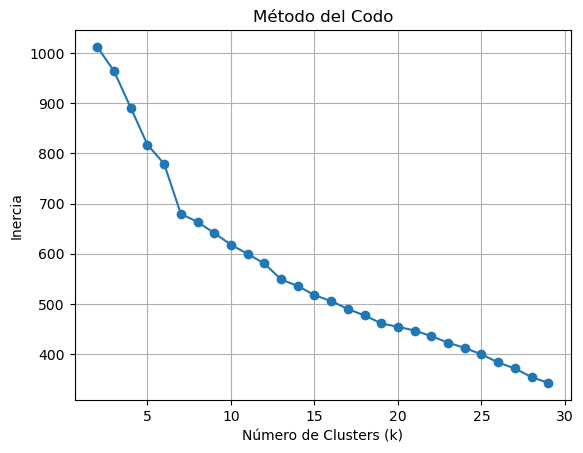

In [22]:
inertias = []
k_values = range(2, 30) 

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vectores_motivo)
    inertias.append(kmeans.inertia_)

# Graficar el codo
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)
plt.show()

In [23]:
kmeans = KMeans(n_clusters=16, random_state=42)
labels = kmeans.fit_predict(vectores_motivo)

for frase, label in zip(motivos_contacto, labels):
    print(f"Cluster {label}: {frase}")


Cluster 10: Cargo adicional en la factura.
Cluster 2: Problemas de conexión a internet.
Cluster 7: Aumento de datos en el plan de telefonía móvil.
Cluster 9: Problema con la recepción de canales de televisión por cable.
Cluster 2: Problemas con la velocidad de internet.
Cluster 14: Estado de un reclamo por doble facturación.
Cluster 8: Cambio de plan.
Cluster 9: Problema con la señal de televisión por cable.
Cluster 12: Cancelación del servicio de teléfono fijo.
Cluster 5: Cargo incorrecto por roaming internacional.
Cluster 6: Cobro de servicios adicionales no solicitados.
Cluster 10: Cobro inesperado en la boleta por paquetes de datos adicionales.
Cluster 7: Inestabilidad de señal en el celular.
Cluster 2: Problemas de conexión a internet.
Cluster 1: Proceso de portabilidad.
Cluster 15: Traslado de servicio de internet a una nueva dirección.
Cluster 9: Suspensión temporal del servicio de internet y televisión.
Cluster 9: Problemas con el servicio de televisión.
Cluster 4: Interés en c

In [24]:
df['cluster motivo de contacto'] = labels

In [25]:
motivo_prompt = PromptTemplate.from_template(
    "Given los siguientes motivos de contacto from clientes:\n{motivos}\n\n"
    "Generate una etiqueta general en Spanish, corta (máximo 5 palabras), que summarize el main tema del grupo."
)
pipeline_motivo = RunnableSequence(motivo_prompt | llm | StrOutputParser())

In [26]:
df['label cluster motivo de contacto'] = np.nan

In [27]:
cluster_labels = {}
for cluster_id in tqdm(df['cluster motivo de contacto'].unique()):
    motivos = "\n".join(df[df['cluster motivo de contacto'] == cluster_id]['motivo de contacto'].tolist())
    etiqueta = pipeline_motivo.invoke({"motivos": motivos})
    etiqueta = re.sub(r'[^\w\sáéíóúÁÉÍÓÚñÑ]', '', etiqueta).strip()
    cluster_labels[cluster_id] = etiqueta

100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


In [28]:
list(cluster_labels.values())

['Discrepancias en facturación',
 'Problemas de conexión a internet',
 'Problemas y consultas móviles',
 'Problemas con servicios de televisión',
 'Problemas de facturación y cobros',
 'Solicitudes de cambio de plan',
 'Problemas con servicios de telecomunicaciones',
 'Roaming internacional para viajes',
 'Problemas de servicios y cobros',
 'Asistencia técnica y portabilidad',
 'Gestión de servicios telefónicos',
 'Interés en servicios de telecomunicaciones',
 'Consultas sobre servicios y pedidos',
 'Cobros indebidos y cancelaciones',
 'Activación de tarjeta SIM',
 'Discrepancias en facturación']

In [29]:
labels = list(set(cluster_labels.values()))
embeddings = model.encode(labels, convert_to_tensor=True)

label_mapping = {label: label for label in labels}
threshold = 0.70

for i in range(len(labels)):
    for j in range(i + 1, len(labels)):
        label_i = label_mapping[labels[i]]
        label_j = label_mapping[labels[j]]
        
        if label_i == label_j:
            continue  
        
        emb_i = model.encode(label_i, convert_to_tensor=True)
        emb_j = model.encode(label_j, convert_to_tensor=True)
        similarity = util.cos_sim(emb_i, emb_j).item()

        print(f'{label_i} vs {label_j} ----> {similarity}')

        if similarity > threshold:
            print('Fusionando')
            label_to_use = min(label_i, label_j, key=len)
            label_to_replace = label_j if label_to_use == label_i else label_i
            for k in label_mapping:
                if label_mapping[k] == label_to_replace:
                    label_mapping[k] = label_to_use

Interés en servicios de telecomunicaciones vs Problemas de facturación y cobros ----> 0.3012310266494751
Interés en servicios de telecomunicaciones vs Cobros indebidos y cancelaciones ----> 0.3131597638130188
Interés en servicios de telecomunicaciones vs Problemas con servicios de televisión ----> 0.4798097014427185
Interés en servicios de telecomunicaciones vs Problemas de conexión a internet ----> 0.5563154220581055
Interés en servicios de telecomunicaciones vs Roaming internacional para viajes ----> 0.22922705113887787
Interés en servicios de telecomunicaciones vs Problemas y consultas móviles ----> 0.6411635875701904
Interés en servicios de telecomunicaciones vs Problemas de servicios y cobros ----> 0.6080306172370911
Interés en servicios de telecomunicaciones vs Gestión de servicios telefónicos ----> 0.8423933982849121
Fusionando
Gestión de servicios telefónicos vs Consultas sobre servicios y pedidos ----> 0.5921739339828491
Gestión de servicios telefónicos vs Activación de tarjet

In [30]:
for cluster_id, old_label in cluster_labels.items():
    cluster_labels[cluster_id] = label_mapping[old_label]

In [31]:
for cluster_id, label in cluster_labels.items():
    df.loc[df['cluster motivo de contacto'] == cluster_id, 'label cluster motivo de contacto'] = label

In [32]:
df['label cluster motivo de contacto'].value_counts()

label cluster motivo de contacto
Problemas y consultas móviles            24
Discrepancias en facturación             19
Problemas de servicios y cobros          17
Solicitudes de cambio de plan            13
Problemas de conexión a internet          9
Problemas con servicios de televisión     6
Asistencia técnica y portabilidad         5
Roaming internacional para viajes         4
Cobros indebidos y cancelaciones          2
Activación de tarjeta SIM                 1
Name: count, dtype: int64

### Clustering problema reportado

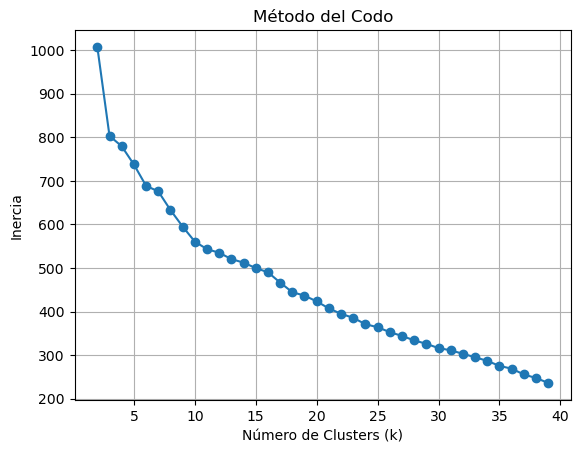

In [33]:
inertias = []
k_values = range(2, 40) 

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vectores_problemas)
    inertias.append(kmeans.inertia_)

plt.plot(k_values, inertias, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)
plt.show()

In [56]:
kmeans = KMeans(n_clusters=35, random_state=42)
labels = kmeans.fit_predict(vectores_problemas)

for frase, label in zip(problemas_reportado, labels):
    print(f"Cluster {label}: {frase}")

Cluster 15: Cargo adicional en la factura que el cliente no reconoce.
Cluster 2: Problema con la estabilidad de la señal de internet.
Cluster 1: ninguno
Cluster 34: No veo algunos canales.
Cluster 5: Problema con la velocidad de internet, especialmente en las noches.
Cluster 13: El cliente no ha recibido respuesta sobre su reclamo de doble facturación.
Cluster 30: El cliente siente que está pagando de más por su plan actual, ya que no utiliza todos los beneficios.
Cluster 12: El cliente no tiene señal en ninguno de los canales de televisión por cable.
Cluster 16: El cliente quiere dar de baja el servicio de teléfono fijo.
Cluster 15: Cargo de roaming internacional que el cliente no utilizó.
Cluster 13: Me están cobrando servicios adicionales que no he solicitado.
Cluster 13: El cliente no fue notificado de que se estaba quedando sin datos ni de que se le iban a cobrar paquetes adicionales.
Cluster 14: Se reporta una señal muy inestable en el celular del cliente, con cortes en las llama

In [57]:
df['cluster problema reportado'] = labels

In [58]:
problema_prompt = PromptTemplate.from_template(
    "Given los siguientes problemas, errores o insatisfacciones from clientes:\n{problemas}\n\n"
    "Identify el problema central que aparece en la mayoría de ellos.\n"
    "Return una etiqueta en español, corta (máximo 5 palabras), que capture el issue principal del grupo."
)
pipeline_problema = RunnableSequence(problema_prompt | llm | StrOutputParser())

In [59]:
df['label cluster problema reportado'] = np.nan

In [60]:
cluster_labels = {}
for cluster_id in tqdm(df['cluster problema reportado'].unique()):
    problemas = "\n".join(df[df['cluster problema reportado'] == cluster_id]['problema reportado'].tolist())
    etiqueta = pipeline_problema.invoke({"problemas": problemas})
    etiqueta = re.sub(r'[^\w\sáéíóúÁÉÍÓÚñÑ]', '', etiqueta).strip()
    cluster_labels[cluster_id] = etiqueta

100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


In [62]:
list(cluster_labels.values())

['Cargos adicionales no reconocidos',
 'Inestabilidad de la señal de internet',
 'Falta de insatisfacción reportada',
 'Problemas de señal de televisión',
 'Problemas de conexión a internet',
 'Cobros no autorizados o erróneos',
 'Precios excesivos del plan',
 'Falta de señal de televisión',
 'Cancelación de servicios telefónicos',
 'Inestabilidad de señal móvil',
 'Aumento de precios y cancelaciones',
 'Problemas de acceso a la app',
 'Problemas de conexión y señal',
 'Problemas de cobertura e internet',
 'Falta de conexión a internet',
 'Cobros inesperados y retrasos',
 'Problemas de cobertura',
 'Falta de servicio de internet',
 'Fidelización del cliente',
 'Falta de factura electrónica',
 'Cobro indebido de servicios',
 'Necesidad de más datos',
 'Falta de conexión a internet',
 'Falta de información sobre permanencia',
 'Problemas de hardware del teléfono',
 'Falta de señal móvil',
 'Percepción de alto costo',
 'Problemas con el cambio de plan',
 'Cobros erróneos en facturación',


In [63]:
labels = list(set(cluster_labels.values()))
embeddings = model.encode(labels, convert_to_tensor=True)

label_mapping = {label: label for label in labels}
threshold = 0.78

for i in range(len(labels)):
    for j in range(i + 1, len(labels)):
        label_i = label_mapping[labels[i]]
        label_j = label_mapping[labels[j]]
        
        if label_i == label_j:
            continue  
        
        emb_i = model.encode(label_i, convert_to_tensor=True)
        emb_j = model.encode(label_j, convert_to_tensor=True)
        similarity = util.cos_sim(emb_i, emb_j).item()

        print(f'{label_i} vs {label_j} ----> {similarity}')

        if similarity > threshold:
            print('Fusionando')
            label_to_use = min(label_i, label_j, key=len)
            label_to_replace = label_j if label_to_use == label_i else label_i
            for k in label_mapping:
                if label_mapping[k] == label_to_replace:
                    label_mapping[k] = label_to_use

Aumento de precios y cancelaciones vs Cobros inesperados y retrasos ----> 0.5715305805206299
Aumento de precios y cancelaciones vs Percepción de alto costo ----> 0.6187264323234558
Aumento de precios y cancelaciones vs Problemas con el chip bancario ----> 0.1845647394657135
Aumento de precios y cancelaciones vs Cortes de señal de internet ----> 0.23082417249679565
Aumento de precios y cancelaciones vs Necesidad de más datos ----> 0.291206419467926
Aumento de precios y cancelaciones vs Cargos adicionales no reconocidos ----> 0.4403521418571472
Aumento de precios y cancelaciones vs Problemas de cobertura e internet ----> 0.3532092273235321
Aumento de precios y cancelaciones vs Falta de señal móvil ----> 0.17924271523952484
Aumento de precios y cancelaciones vs Cobros no autorizados o erróneos ----> 0.3549267649650574
Aumento de precios y cancelaciones vs Cobros erróneos en facturación ----> 0.44161444902420044
Aumento de precios y cancelaciones vs Bloqueo por deuda pendiente ----> 0.3116

In [64]:
for cluster_id, old_label in cluster_labels.items():
    cluster_labels[cluster_id] = label_mapping[old_label]

In [65]:
for cluster_id, label in cluster_labels.items():
    df.loc[df['cluster problema reportado'] == cluster_id, 'label cluster problema reportado'] = label

In [66]:
df['label cluster problema reportado'].value_counts()

label cluster problema reportado
Falta de insatisfacción reportada         19
Falta de conexión a internet              11
Cargos adicionales no reconocidos         10
Cobros no autorizados o erróneos          10
Cancelación de servicios telefónicos       4
Falta de señal móvil                       4
Problemas de cobertura                     4
Falta de señal de televisión               3
Precios excesivos del plan                 3
Cobros inesperados y retrasos              3
Necesidad de más datos                     3
Cobro indebido de servicios                2
Falta de servicio y atención               2
Cobros erróneos en facturación             2
Problemas con el cambio de plan            2
Falta de información sobre permanencia     2
Fidelización del cliente                   2
Problemas de conexión y señal              2
Aumento de precios y cancelaciones         2
Falta de factura electrónica               1
Inestabilidad de la señal de internet      1
Problemas de hardware 

### Clustering Necesidad no satisfecha

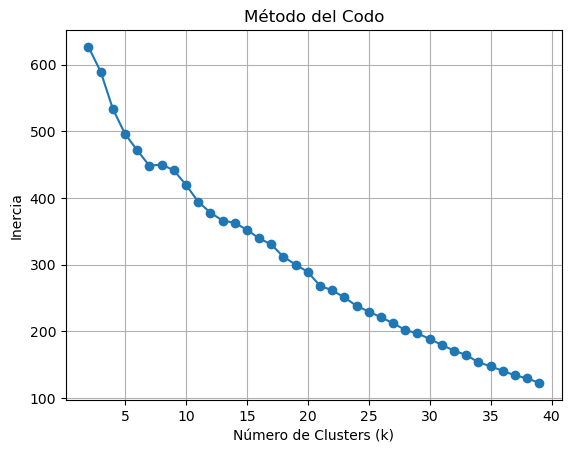

In [67]:
inertias = []
k_values = range(2, 40) 

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vectores_necesidad)
    inertias.append(kmeans.inertia_)

# Graficar el codo
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)
plt.show()

In [68]:
kmeans = KMeans(n_clusters=36, random_state=42)
labels = kmeans.fit_predict(vectores_necesidad)

for frase, label in zip(necesidad_no_satisfecha, labels):
    print(f"Cluster {label}: {frase}")

Cluster 4: La cliente podría necesitar una mejor comunicación sobre los cargos y servicios adicionales para evitar confusiones en el futuro.
Cluster 1: none
Cluster 1: none
Cluster 1: none
Cluster 1: none
Cluster 24: El cliente necesita una confirmación clara sobre el proceso y el tiempo estimado para la devolución de su dinero.
Cluster 1: none
Cluster 9: El cliente necesita más opciones de canales deportivos en su plan actual.
Cluster 1: none
Cluster 0: El cliente necesita una solución más efectiva para evitar cargos no deseados por roaming internacional en el futuro.
Cluster 17: Necesita una garantía escrita de que no se activarán servicios adicionales sin su consentimiento en el futuro.
Cluster 4: El cliente necesita una mejor comunicación sobre el consumo de datos y notificaciones de cargos adicionales.
Cluster 13: El cliente necesita ser notificado proactivamente sobre interrupciones de servicio en su área.
Cluster 5: La cliente necesita una solución más rápida y efectiva para los

In [69]:
df['cluster necesidad no satisfecha'] = labels

In [70]:
need_prompt = PromptTemplate.from_template(
    "Dado este listado de unmet needs expresados por clientes:\n{necesidad}\n\n"
    "Identifica la necesidad no satisfecha más común o más importante entre todas.\n"
    "Return just one etiqueta en español — debe ser clara, concreta y short (máximo 5 palabras) — que capture ese unmet need central.\n"
    "Don’t add context or explanations. Solo la etiqueta."
)
pipeline_need = RunnableSequence(need_prompt | llm | StrOutputParser())

In [71]:
df['label cluster necesidad no satisfecha'] = np.nan

In [72]:
cluster_labels = {}
for cluster_id in tqdm(df['cluster necesidad no satisfecha'].unique()):
    necesidad = "\n".join(df[df['cluster necesidad no satisfecha'] == cluster_id]['necesidad no satisfecha'].tolist())
    etiqueta = pipeline_need.invoke({"necesidad": necesidad})
    etiqueta = re.sub(r'[^\w\sáéíóúÁÉÍÓÚñÑ]', '', etiqueta).strip()
    cluster_labels[cluster_id] = etiqueta

100%|██████████| 36/36 [00:32<00:00,  1.10it/s]


In [73]:
list(cluster_labels.values())

['Comunicación clara sobre cargos',
 'Ninguna necesidad expresada',
 'Confirmación de procesos y tiempos',
 'Más canales deportivos disponibles',
 'Prevención de cargos no deseados',
 'Consentimiento garantizado',
 'Comunicación proactiva y clara',
 'Conexión a internet confiable',
 'Instructivo claro para idioma',
 'Opciones económicas y flexibles',
 'Tutorial detallado de MiRed',
 'Control remoto universal adicional',
 'Estabilidad y velocidad de internet',
 'Configuración WiFi urgente',
 'Más datos para punto de acceso',
 'Gestión eficiente de facturas',
 'Mejorar señal del decodificador',
 'Cambio de titularidad simplificado',
 'Capacitación en configuración de equipos',
 'Solución rápida de internet',
 'Tutorial acceso plataforma streaming',
 'Solución temporal de cobertura',
 'Educación sobre fraude telefónico',
 'Claridad en términos y condiciones',
 'Notificaciones de cambios en cuenta',
 'Mejorar estabilidad de señal móvil',
 'Flexibilidad en planes de datos',
 'Reembolso inme

In [74]:
labels = list(set(cluster_labels.values()))
embeddings = model.encode(labels, convert_to_tensor=True)

label_mapping = {label: label for label in labels}
threshold = 0.75

for i in range(len(labels)):
    for j in range(i + 1, len(labels)):
        label_i = label_mapping[labels[i]]
        label_j = label_mapping[labels[j]]
        
        if label_i == label_j:
            continue  
        
        emb_i = model.encode(label_i, convert_to_tensor=True)
        emb_j = model.encode(label_j, convert_to_tensor=True)
        similarity = util.cos_sim(emb_i, emb_j).item()

        print(f'{label_i} vs {label_j} ----> {similarity}')

        if similarity > threshold:
            print('Fusionando')
            label_to_use = min(label_i, label_j, key=len)
            label_to_replace = label_j if label_to_use == label_i else label_i
            for k in label_mapping:
                if label_mapping[k] == label_to_replace:
                    label_mapping[k] = label_to_use

Consentimiento garantizado vs Comunicación proactiva y clara ----> 0.3904488682746887
Consentimiento garantizado vs Tutorial acceso plataforma streaming ----> 0.009372508153319359
Consentimiento garantizado vs Más canales deportivos disponibles ----> 0.11878839135169983
Consentimiento garantizado vs Confirmación de deudas pendientes ----> 0.31579679250717163
Consentimiento garantizado vs Configuración WiFi urgente ----> -0.02007291093468666
Consentimiento garantizado vs Estabilidad y velocidad de internet ----> 0.08288228511810303
Consentimiento garantizado vs Control remoto universal adicional ----> 0.2719467282295227
Consentimiento garantizado vs Falta de transparencia en facturación ----> 0.33643341064453125
Consentimiento garantizado vs Comunicación clara sobre cargos ----> 0.42113083600997925
Consentimiento garantizado vs Más datos para punto de acceso ----> 0.08755706995725632
Consentimiento garantizado vs Notificaciones de cambios en cuenta ----> 0.31221163272857666
Consentimien

In [75]:
for cluster_id, old_label in cluster_labels.items():
    cluster_labels[cluster_id] = label_mapping[old_label]

In [76]:
for cluster_id, label in cluster_labels.items():
    df.loc[df['cluster necesidad no satisfecha'] == cluster_id, 'label cluster necesidad no satisfecha'] = label

In [77]:
df['label cluster necesidad no satisfecha'].value_counts()

label cluster necesidad no satisfecha
Ninguna necesidad expresada                  30
Comunicación proactiva y clara                6
Comunicación clara sobre cargos               5
Solución rápida de internet                   5
Reembolso inmediato efectivo                  4
Prevención de cargos no deseados              4
Conexión a internet confiable                 4
Transparencia en cargos y garantías           4
Flexibilidad en planes de datos               3
Estabilidad y velocidad de internet           3
Tutorial acceso plataforma streaming          2
Claridad en términos y condiciones            2
Notificaciones de cambios en cuenta           2
Claridad en cambios de plan                   2
Fiabilidad en facturación y suscripciones     2
Confirmación de procesos y tiempos            2
Solución temporal de cobertura                2
Educación sobre fraude telefónico             1
Mejorar estabilidad de señal móvil            1
Confirmación de deudas pendientes             1
Ca

In [78]:
df.to_excel('Analisis transcripciones.xlsx',index=False)